# Stratification v1

In [1]:
import sys

sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils.bootstrap import bootstrap_experiment
from utils.prop_utils import prop_probs
from utils.strat_utils import calculate_stratified_effects

In [3]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

* Propensity scores help in balancing the distribution of observed covariates between the treatment and control groups. This balance is crucial because it allows for a fair comparison of outcomes between these groups.
* Now, by summarizing the covariates into a single score, propensity scores simplify the matching process. This makes it easier to compare units that are similar in terms of their covariates.
* Stratification ensures that the treatment and control groups are comparable by ensuring overlap in the propensity score distribution.

Within each stratum $k$, we calculate the difference in mean outcomes:

$\beta_{k} = E[Y^a_k - Y^{a'}_k]$

We're using the differences in revenues in 1978:

$\beta_{k} = E[{Re_{78}^{a=1}}_k - {Re_{78}^{a=0}}_k]$

and then take the weighted average:

weight, $w_k = \frac{n_{T_k}}{n_T}$

$\beta = \sum_{k=1}^{K} w_k \beta_{k} = \sum_{k=1}^{K} \frac{n_{T_k}}{n_T} \left( E[Y^a_k] - E[Y^{a'}_k] \right)$


Equivalentally,

$\beta_{k} = \frac{1}{n_{T_k}} \sum_{i \in T_k} Y_i - \frac{1}{n_{C_k}} \sum_{i \in C_k} Y_i$

Where, $T_k$ and $C_k$ represented the treatment and the control groups

## Experimental Data

In [4]:
propensity_probabilities = prop_probs(
    lalonde_exp,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)

lalonde_exp = pd.merge(lalonde_exp, propensity_probabilities, on="id")

1. Divide the dataset into a specified number of strata based on the propensity scores.
2. Loop through each stratum:  Compute the treatment effect as the difference in mean outcomes between treated and control units.
3. Calculate the overall treatment effect by taking a weighted average of the stratum-specific effects, with weights proportional to the number of treated units in each stratum.
4. Perform a bootstrap experiment to validate the treatment effect estimates across different numbers of strata.

In [5]:
bootstrap_results = {}
num_strata_values = range(1, 35, 3)

for num_strata in num_strata_values:
    bootstrap_results[num_strata] = bootstrap_experiment(
        lalonde_exp,
        calculate_stratified_effects,
        num_exp=1,
        n=50,
        ci=95,
        prop_col="propensity",
        treatment_col="treat",
        outcome_col="re78",
        num_strata=num_strata,
    )

Running experiments: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


In [6]:
data = []
for num_strata, ci_array in bootstrap_results.items():
    mean = ci_array[0, 0]
    lower = ci_array[0, 1]
    upper = ci_array[0, 2]
    data.append([num_strata, mean, lower, upper])

ci_df = pd.DataFrame(data, columns=["num_strata", "mean", "lower_ci", "upper_ci"])

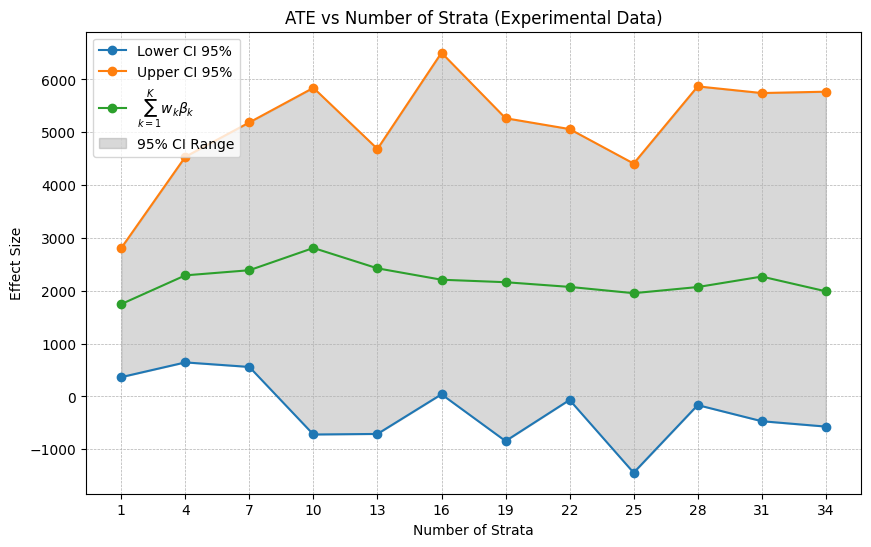

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(ci_df["num_strata"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["num_strata"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["num_strata"],
    ci_df["mean"],
    label="$\\sum_{k=1}^{K} w_k \\beta_{k}$",
    marker="o",
)

plt.fill_between(
    ci_df["num_strata"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["num_strata"])
plt.xlabel("Number of Strata")
plt.ylabel("Effect Size")
plt.title("ATE vs Number of Strata (Experimental Data)")
plt.legend()
plt.show()

## Observational Data

In [8]:
propensity_probabilities = prop_probs(
    lalonde_obs,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)

In [9]:
lalonde_obs = pd.merge(lalonde_obs, propensity_probabilities, on="id")

In [10]:
bootstrap_results = {}
num_strata_values = range(1, 35, 3)

for num_strata in num_strata_values:
    bootstrap_results[num_strata] = bootstrap_experiment(
        lalonde_obs,
        calculate_stratified_effects,
        num_exp=1,
        n=50,
        ci=95,
        prop_col="propensity",
        treatment_col="treat",
        outcome_col="re78",
        num_strata=num_strata,
    )

Running experiments: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


In [11]:
data = []
for num_strata, ci_array in bootstrap_results.items():
    mean = ci_array[0, 0]
    lower = ci_array[0, 1]
    upper = ci_array[0, 2]
    data.append([num_strata, mean, lower, upper])

ci_df = pd.DataFrame(data, columns=["num_strata", "mean", "lower_ci", "upper_ci"])

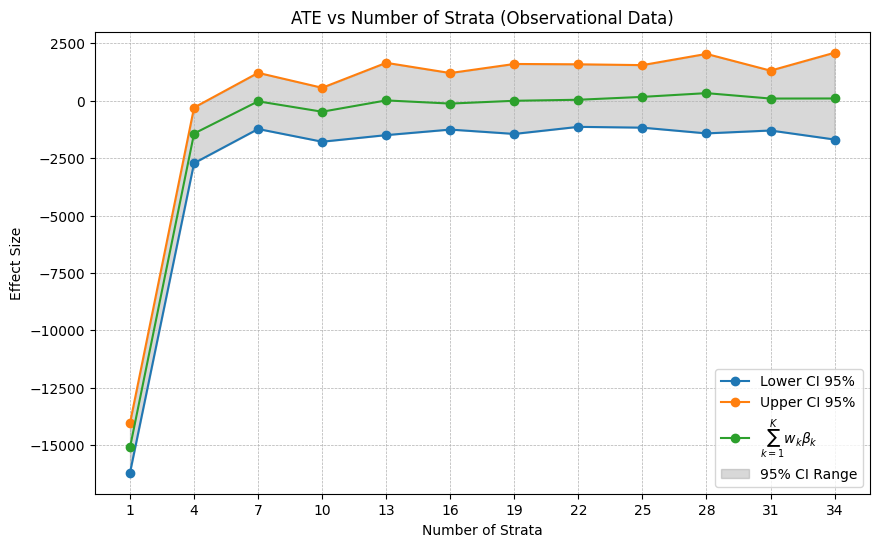

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(ci_df["num_strata"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["num_strata"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["num_strata"],
    ci_df["mean"],
    label="$\\sum_{k=1}^{K} w_k \\beta_{k}$",
    marker="o",
)

plt.fill_between(
    ci_df["num_strata"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["num_strata"])
plt.xlabel("Number of Strata")
plt.ylabel("Effect Size")
plt.title("ATE vs Number of Strata (Observational Data)")
plt.legend()
plt.show()

In [13]:
ci_df

,num_strata,mean,lower_ci,upper_ci
0,1,-15100.428935,-16200.037131,-14037.321997
1,4,-1427.379011,-2717.514914,-296.036742
2,7,-24.482345,-1229.849327,1216.029839
3,10,-477.303247,-1783.473135,565.719068
4,13,15.479795,-1496.294223,1653.136330
5,16,-122.781279,-1255.034480,1207.699937
6,19,-0.579613,-1444.398019,1602.462007
7,22,43.962468,-1135.856697,1587.967164
8,25,169.246065,-1170.781639,1552.620102
9,28,332.274370,-1420.968084,2041.366195


Our ATEs are still biased, let's use the difference in revenues and see our results.